## Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

### Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

In [2068]:
import numpy as np
import pandas as pd
import random
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2069]:
matplotlib.rcParams.update({'font.size': 14})

In [2070]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """Оценка качества модели и график preds vs true"""

    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))

    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [2071]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

# Загрузка данных

**Описание датасета**
    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

In [2072]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [2073]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [2074]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [2075]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [2076]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## EDA

Датасет содержит три категориальных признака (Ecology_2, Ecology_3, Shops_2). По двум признакам есть пропущенные значения (LifeSquare, Healthcare_1).

**Целевая переменная**

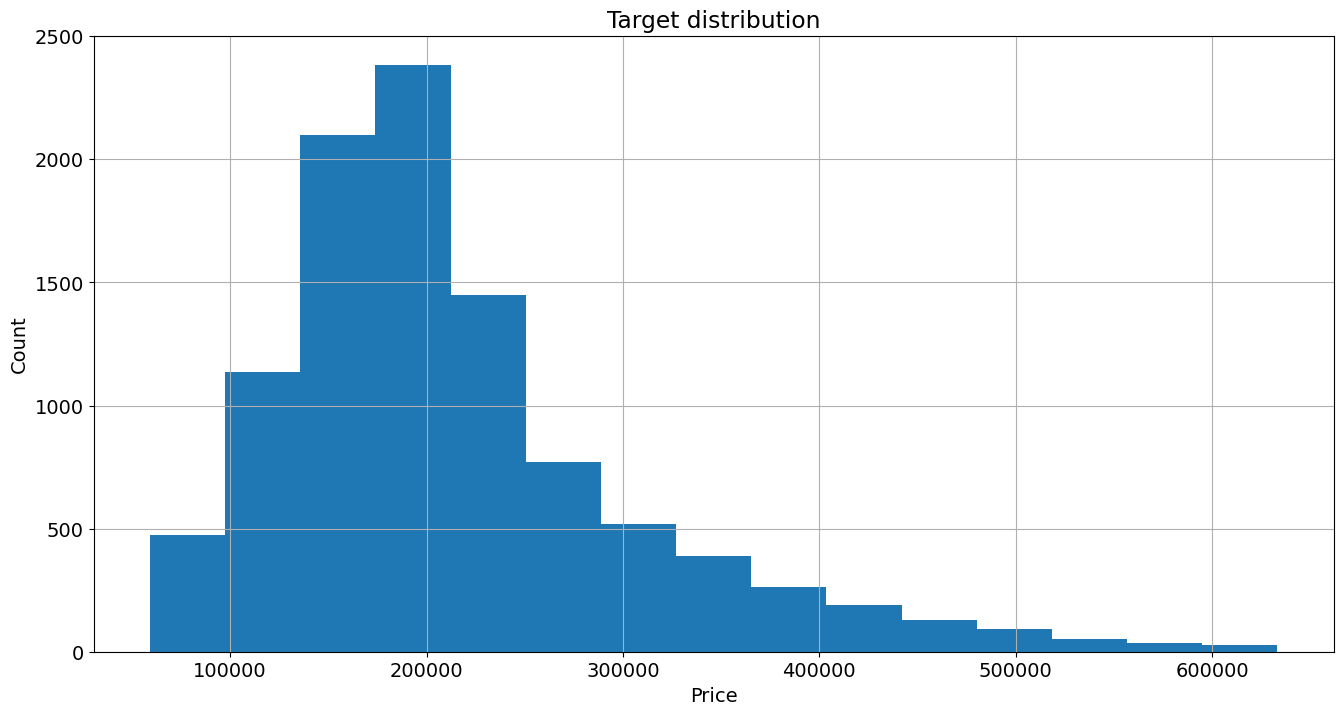

In [2077]:
plt.figure(figsize=(16,8))

train_df['Price'].hist(bins=15)
plt.xlabel('Price')
plt.ylabel('Count')

plt.title('Target distribution')
plt.show()

In [2078]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Square'}>,
        <Axes: title={'center': 'LifeSquare'}>,
        <Axes: title={'center': 'KitchenSquare'}>],
       [<Axes: title={'center': 'Floor'}>,
        <Axes: title={'center': 'HouseFloor'}>,
        <Axes: title={'center': 'HouseYear'}>,
        <Axes: title={'center': 'Ecology_1'}>],
       [<Axes: title={'center': 'Social_1'}>,
        <Axes: title={'center': 'Social_2'}>,
        <Axes: title={'center': 'Social_3'}>,
        <Axes: title={'center': 'Healthcare_1'}>],
       [<Axes: title={'center': 'Helthcare_2'}>,
        <Axes: title={'center': 'Shops_1'}>,
        <Axes: title={'center': 'Price'}>, <Axes: >]], dtype=object)

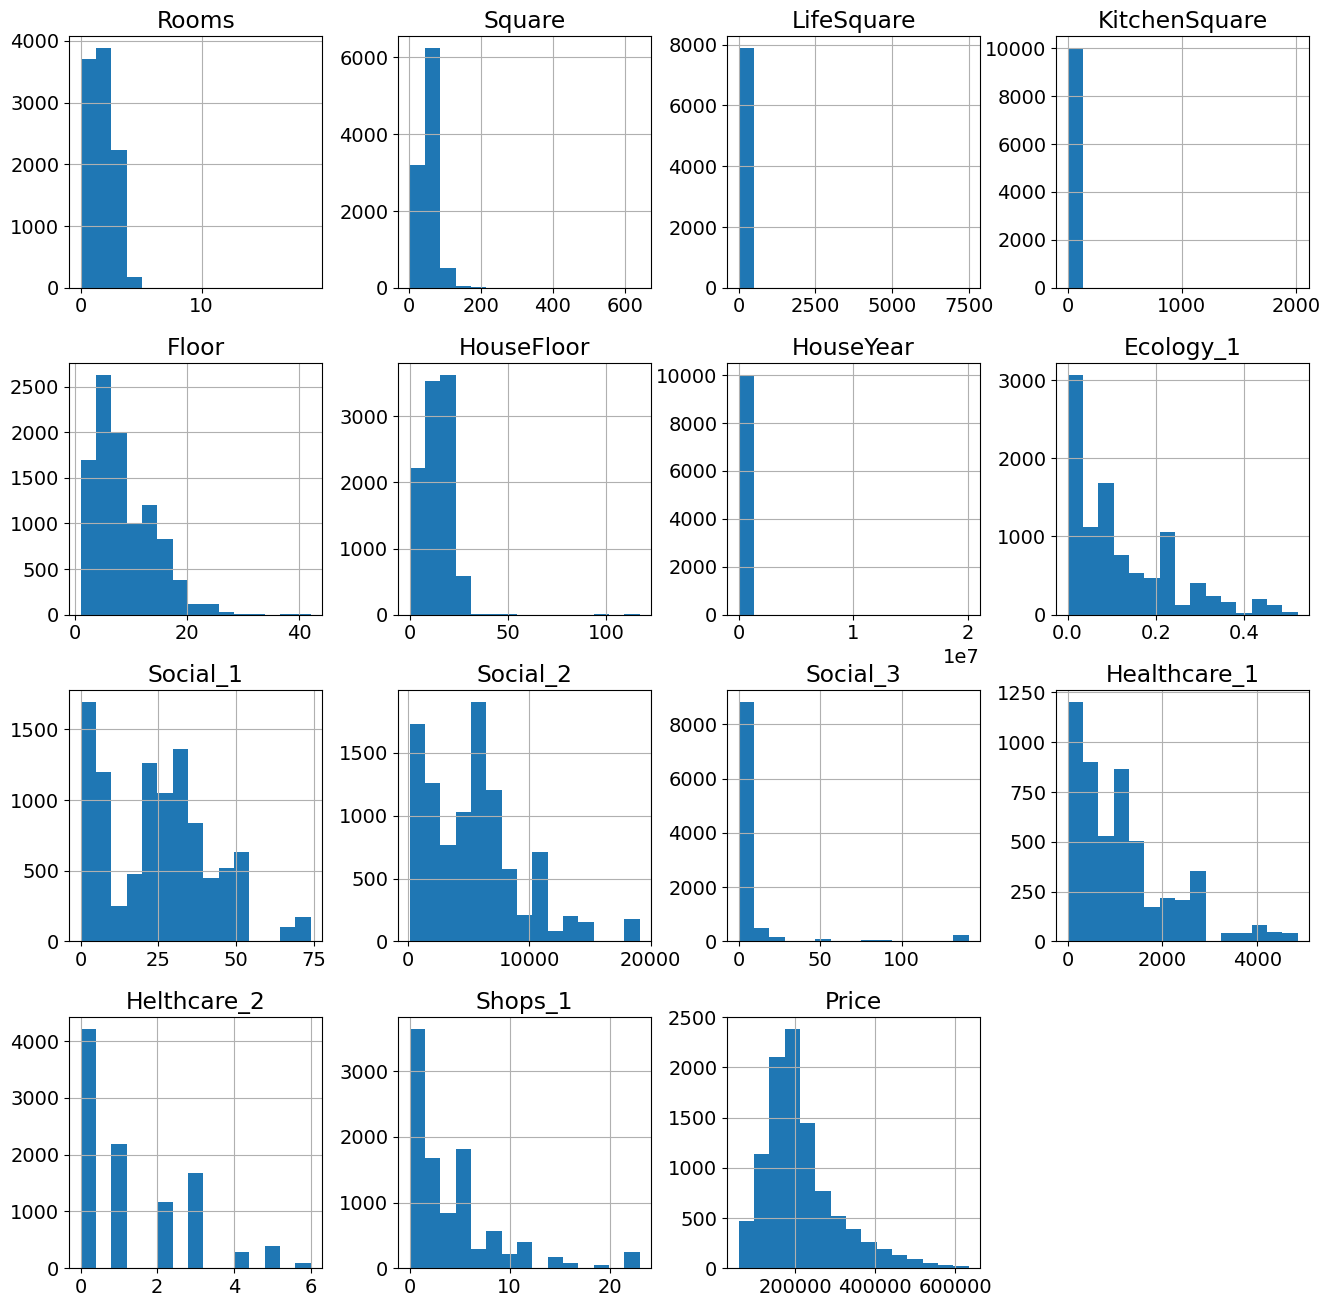

In [2079]:
train_df.hist(figsize=(16,16), bins=15)

In [2080]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [2081]:
train_df['DistrictId'].value_counts()

DistrictId
27     851
1      652
23     565
6      511
9      294
      ... 
117      1
199      1
207      1
205      1
209      1
Name: count, Length: 205, dtype: int64

In [2082]:
train_df['Ecology_2'].value_counts()

Ecology_2
B    9903
A      97
Name: count, dtype: int64

In [2083]:
train_df['Ecology_3'].value_counts()

Ecology_3
B    9725
A     275
Name: count, dtype: int64

In [2084]:
train_df['Shops_2'].value_counts()

Shops_2
B    9175
A     825
Name: count, dtype: int64

**Обработка выбросов**

In [2085]:
train_df['Rooms'].value_counts()

Rooms
2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: count, dtype: int64

In [2086]:
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 5), 'Rooms'] = train_df['Rooms'].median()

In [2087]:
train_df['Rooms'].value_counts()

Rooms
2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: count, dtype: int64

In [2088]:
train_df['KitchenSquare'].value_counts()

KitchenSquare
1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
37.0         2
43.0         2
30.0         2
25.0         2
51.0         2
32.0         2
58.0         2
41.0         2
48.0         1
72.0         1
2014.0       1
53.0         1
78.0         1
66.0         1
42.0         1
96.0         1
23.0         1
36.0         1
26.0         1
73.0         1
31.0         1
63.0         1
60.0         1
29.0         1
40.0         1
62.0         1
35.0         1
75.0         1
84.0         1
21.0         1
54.0         1
1970.0       1
27.0         1
39.0         1
123.0        1
Name: count, dtype: int64

In [2089]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [2090]:
train_df.loc[train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975), 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

In [2091]:
train_df['KitchenSquare'].value_counts()

KitchenSquare
4.0     3222
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: count, dtype: int64

In [2092]:
train_df['Floor'].value_counts()

Floor
4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
31      1
37      1
33      1
Name: count, dtype: int64

In [2093]:
train_df['HouseFloor'].value_counts()

HouseFloor
17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
32.0        4
37.0        4
28.0        3
48.0        2
39.0        2
99.0        2
45.0        1
44.0        1
47.0        1
36.0        1
29.0        1
38.0        1
117.0       1
26.0        1
31.0        1
Name: count, dtype: int64

In [2094]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

np.int64(1825)

In [2095]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [2096]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = train_df['HouseFloor']

In [2097]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

np.int64(0)

In [2098]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
585         2020
1499        2020
2493        2020
          ...   
7611        1916
910         1914
5111        1912
2656        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [2099]:
train_df.loc[train_df['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year

In [2100]:
train_df['HouseYear'].sort_values(ascending=False)

4189    2024
1497    2024
585     2020
1499    2020
2493    2020
        ... 
7611    1916
910     1914
5111    1912
2656    1912
9317    1910
Name: HouseYear, Length: 10000, dtype: int64

**Обработка пропусков**

In [2101]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [2102]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare'] - 4

In [2103]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [2104]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

**Препроцессинг**

In [2105]:
class Preprocessing:
    '''Подготовка данных'''

    def __init__(self):
        self.kitchen_sqare_quantile = None

    def fit(self, df):
        self.kitchen_sqare_quantile = df['KitchenSquare'].quantile(.975)

    def transform(self, df):
        '''Трансформация данных'''
        #Rooms
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] > 5), 'Rooms'] = df['Rooms'].median()

        #KitchenSquare
        df.loc[df['KitchenSquare'] > self.kitchen_sqare_quantile, 'KitchenSquare'] =df['KitchenSquare'].median()
        df.loc[df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

        #HouseFloor/Floor
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df['HouseFloor']

        #HouseYear
        df.loc[df['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year

        #LifeSquare
        df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df['Square'] - df['KitchenSquare'] - 4

        #Healthcare_1
        df.drop('Healthcare_1', axis=1, inplace=True)


        return df

## Построение новых признаков

### Dummies

In [2106]:

train_df['Ecology_2'] = pd.factorize(train_df['Ecology_2'])[0]
train_df['Ecology_3'] = pd.factorize(train_df['Ecology_3'])[0]
train_df['Shops_2'] = pd.factorize(train_df['Shops_2'])[0]

### New Features

In [2107]:
med_price_by_district = train_df.groupby(['DistrictId','Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district.head(10)

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126
5,1,3.0,244005.272380
6,1,4.0,277290.705058
7,10,1.0,167742.760878
8,10,2.0,217749.656911
9,10,3.0,267667.016108


In [2108]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,0,0,33,7976,5,0,11,0,184966.930730,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,0,0,46,10309,1,1,16,0,300009.450063,300009.450063
2,4765,53,2.0,44.947953,29.197612,4.0,8,12.0,1968,0.049637,0,0,34,7759,0,1,3,0,220925.908524,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,0,0,23,5735,3,0,5,0,175616.227217,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,0,0,35,5776,1,2,4,0,150226.531644,158539.052715


In [2109]:
def floor_to_cat(df):
    bins = [0,3,5,9,15, df['Floor'].max()]
    df['floor_cat'] = pd.cut(df['Floor'], bins = bins, labels=False)
    return df

def year_to_cat(df):
    bins = [0,1950,1980,2000,2010, df['HouseYear'].max()]
    df['year_cat'] = pd.cut(df['HouseYear'], bins = bins, labels=False)
    return df

In [2110]:
train_df = floor_to_cat(train_df)
train_df = year_to_cat(train_df)
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict,floor_cat,year_cat
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,33,7976,5,0,11,0,184966.930730,207786.135836,2,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,46,10309,1,1,16,0,300009.450063,300009.450063,2,1
2,4765,53,2.0,44.947953,29.197612,4.0,8,12.0,1968,0.049637,...,34,7759,0,1,3,0,220925.908524,263206.223152,2,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,23,5735,3,0,5,0,175616.227217,166809.665642,2,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,35,5776,1,2,4,0,150226.531644,158539.052715,3,1
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,35,7715,4,0,6,0,215898.447742,466753.618497,1,4
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,...,20,4386,14,1,5,0,296021.204377,234421.454601,0,1
7,11993,74,2.0,80.312926,72.312926,4.0,13,13.0,1977,0.075779,...,6,1437,3,0,2,0,221244.156664,243031.695525,3,1
8,5172,1,2.0,64.511437,56.511437,4.0,9,17.0,1977,0.007122,...,1,264,0,0,1,0,229102.795999,202666.310126,2,1
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,...,6,1437,3,0,2,0,95380.220993,102069.270740,3,4


In [2111]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head(10)

,year_cat,floor_cat,MedPriceByFloorYear
0,0,0,380359.112959
1,0,1,324303.812481
2,0,2,429090.881284
3,0,3,274992.472366
4,1,0,178890.558191
5,1,1,186265.568592
6,1,2,192048.442631
7,1,3,184374.328532
8,1,4,175503.767602
9,2,0,205210.068542


In [2112]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict,floor_cat,year_cat,MedPriceByFloorYear
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,0,184966.930730,207786.135836,2,1,192048.442631
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,0,300009.450063,300009.450063,2,1,192048.442631
2,4765,53,2.0,44.947953,29.197612,4.0,8,12.0,1968,0.049637,...,7759,0,1,3,0,220925.908524,263206.223152,2,1,192048.442631
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,0,175616.227217,166809.665642,2,1,192048.442631
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,0,150226.531644,158539.052715,3,1,184374.328532
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,7715,4,0,6,0,215898.447742,466753.618497,1,4,161744.506404
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,...,4386,14,1,5,0,296021.204377,234421.454601,0,1,178890.558191
7,11993,74,2.0,80.312926,72.312926,4.0,13,13.0,1977,0.075779,...,1437,3,0,2,0,221244.156664,243031.695525,3,1,184374.328532
8,5172,1,2.0,64.511437,56.511437,4.0,9,17.0,1977,0.007122,...,264,0,0,1,0,229102.795999,202666.310126,2,1,192048.442631
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,...,1437,3,0,2,0,95380.220993,102069.270740,3,4,175625.246987


In [2113]:
class FeatureGenerator():
    '''Генерация новых признаков'''

    def __init__(self):
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.floor_max = None
        self.house_year_max = None

    def fit(self, df, y = None):
        df_copy = df.copy()
        if y is not None:
            df_copy['Price'] = y.values
            self.med_price_by_district = df_copy.groupby(['DistrictId','Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})
            self.floor_max = df_copy['Floor'].max()
            self.house_year_max = df_copy['HouseYear'].max()
            df_copy = self.floor_to_cat(df_copy)
            df_copy = self.year_to_cat(df_copy)
            self.med_price_by_floor_year = df_copy.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorYear'})

    def transform(self, df):
        df['Ecology_2'] = pd.factorize(df['Ecology_2'])[0]
        df['Ecology_3'] = pd.factorize(df['Ecology_3'])[0]
        df['Shops_2'] = pd.factorize(df['Shops_2'])[0]

        df = self.floor_to_cat(df)
        df = self.year_to_cat(df)

        df = df.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        df = df.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')

        return df

    def floor_to_cat(self, df):
        bins = [0,3,5,9,15, df['Floor'].max()]
        df['floor_cat'] = pd.cut(df['Floor'], bins = bins, labels=False)
        return df

    def year_to_cat(self, df):
        bins = [0,1950,1980,2000,2010, df['HouseYear'].max()]
        df['year_cat'] = pd.cut(df['HouseYear'], bins = bins, labels=False)
        return df

# Разбиение на train и test

In [2114]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

x = train_df.drop(columns='Price')
y = train_df['Price']

In [2115]:
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size=0.33, shuffle=True, random_state=11)

In [2116]:
preprocessor = Preprocessing()
preprocessor.fit(x_train)

x_train = preprocessor.transform(x_train)
x_valid = preprocessor.transform(x_valid)
test_df = preprocessor.transform(test_df)
x_train.shape, x_valid.shape, test_df.shape

((6700, 18), (3300, 18), (5000, 18))

In [2117]:
features_gen = FeatureGenerator()
features_gen.fit(x_train,y_train)

x_train = features_gen.transform(x_train)
x_valid = features_gen.transform(x_valid)
test_df = features_gen.transform(test_df)
x_train.shape, x_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [2118]:
x_train.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,2594,45,1.0,56.421113,54.129248,4.0,22,22.0,2016,0.195781,...,23,5212,6,3,2,0,4,4,234713.142502,203480.081002
1,7477,48,1.0,40.469224,37.061960,10.0,19,20.0,2017,0.041125,...,46,9515,5,1,10,0,4,4,204576.421636,203480.081002
2,8355,6,1.0,50.347879,42.347879,4.0,10,17.0,1977,0.243205,...,5,1564,0,0,0,0,3,1,130469.071786,185088.409028
3,13430,27,1.0,47.191767,39.191767,4.0,6,17.0,1977,0.072158,...,2,629,1,0,0,1,2,1,117711.346469,195078.299527
4,3839,31,3.0,78.471987,52.706824,8.0,5,5.0,1957,0.151346,...,32,5889,10,4,1,0,1,1,402938.135858,189115.338060
5,10434,52,2.0,64.093797,65.826312,4.0,10,17.0,1977,0.371149,...,34,7065,1,2,5,0,3,1,169188.936898,185088.409028
6,6436,79,3.0,91.282600,50.819134,11.0,19,25.0,1979,0.307467,...,30,5048,9,2,5,0,4,1,266246.829849,178411.774656
7,12657,17,1.0,32.840311,17.383530,6.0,5,10.0,1969,0.000000,...,18,3374,5,1,2,0,1,1,210311.452939,189115.338060
8,945,6,1.0,40.499791,32.499791,4.0,3,17.0,1977,0.243205,...,5,1564,0,0,0,0,0,1,130469.071786,178895.789799
9,6275,67,1.0,42.435461,34.435461,4.0,15,22.0,2014,0.007720,...,38,4788,2,0,4,0,3,4,172680.530225,175065.504600


# Построение модели

In [2119]:
model = RandomForestRegressor(n_estimators=1000, max_depth=9, max_features=7, random_state=11)
model.fit(x_train,y_train)

RandomForestRegressor(max_depth=9, max_features=7, n_estimators=1000,
                      random_state=11)

### Оценка модели

Train R2:	0.863
Test R2:	0.69


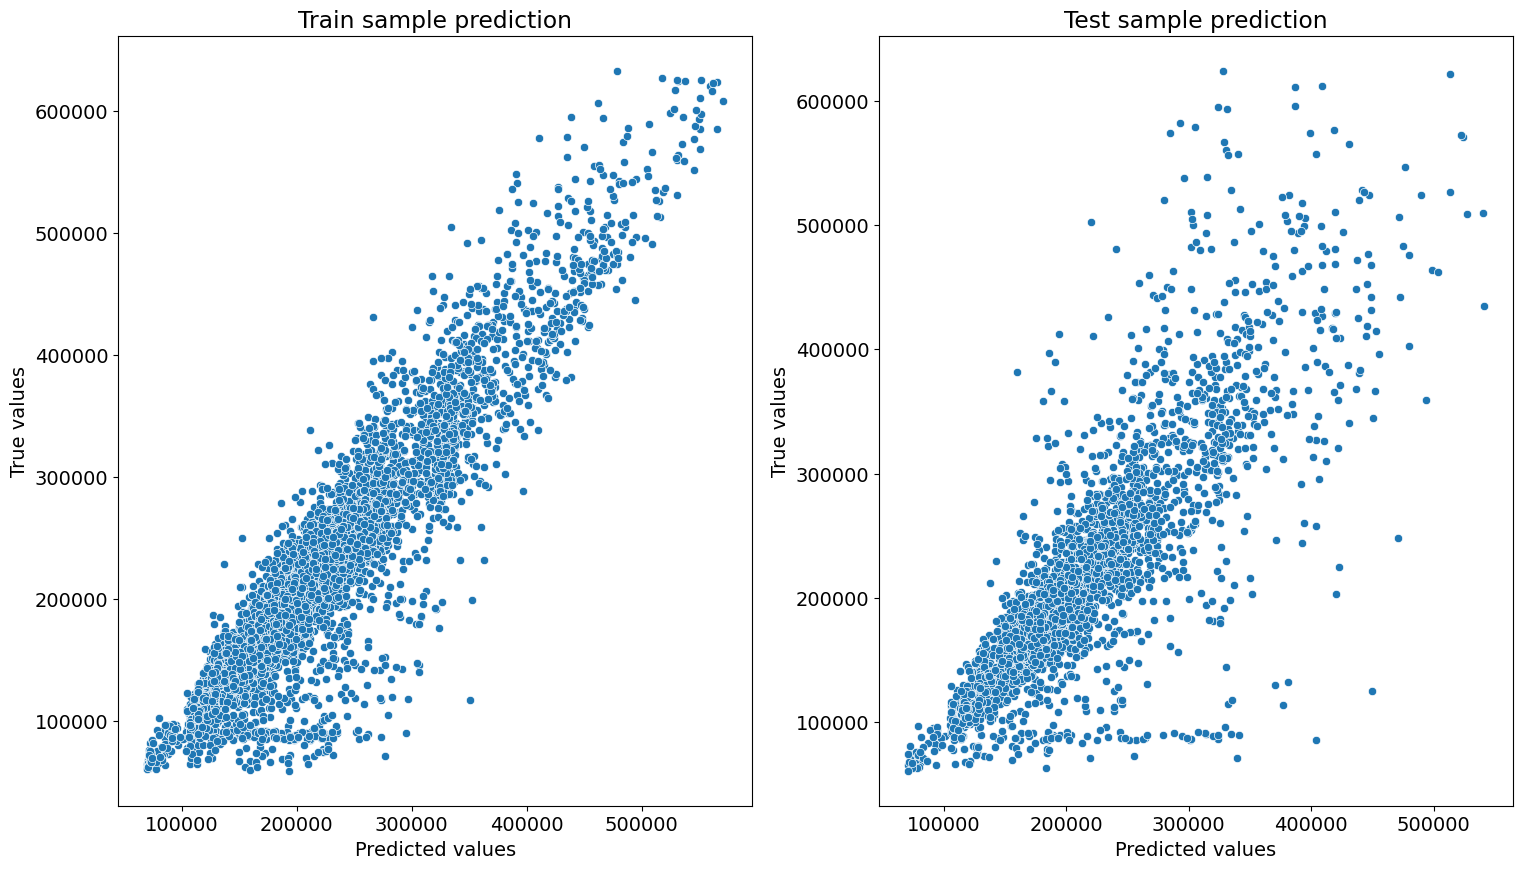

In [2120]:
y_train_pred = model.predict(x_train)
y_valid_pred = model.predict(x_valid)
evaluate_preds(y_train,y_train_pred, y_valid, y_valid_pred)

### Кросс-валидация

In [2121]:
cross_score = cross_val_score(model,x_train,y_train, scoring='r2',cv=KFold(n_splits=5,shuffle=True))
cross_score.mean()

np.float64(0.7549772208428116)

# Предсказание на тестовом датасете

In [2122]:
test_df.shape

(5000, 22)

In [2123]:
predictions = model.predict(test_df)
predictions

array([159453.90979865, 231350.4112893 , 192537.46500178, ...,
       326997.86716174, 196622.26089152, 169176.45530693])

In [2124]:
pred_df = pd.DataFrame(data=predictions,columns=['Price'])

In [2125]:
pred_df.to_csv('prediction_prices.csv', index=False)